<a href="https://colab.research.google.com/github/zhuchangyan/Multimode-fiber-Image-reconstruction/blob/master/Experiment_data_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

搭建神经网络.

2020年1月2号考虑改变输入输出图片的大小，使得训练模型满足实际图片的需求。

2020年1月3日 决定先采用resize实验数据的方式，尽快获得训练结果。

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/Colab Notebooks/MMF data/

/content/drive/My Drive/Colab Notebooks/MMF data


In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle


搭建神经网络 autoencoder

In [0]:
#lrelu函数
def lrelu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)

#输入到网络的数据
#图片28*28,color_channel是1
inputs_ = tf.placeholder(tf.float32, [None, 28, 28, 1])
#原始数据
targets_ = tf.placeholder(tf.float32, [None, 28, 28, 1])


### Encoder
'''
filters: 32个卷积核
kernel_size: 卷积核大小
strides: 长宽步长都是1
padding: 边缘填充
use_bias: 在卷积中添加偏置
activation: 激活函数
'''
with tf.name_scope('en-convolutions'):
    conv1 = tf.layers.conv2d(inputs_, filters=32,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu, )
# 卷积时padding是SAME,所以仍然是28*28
# now 28x28x32
'''
将第一卷积层的结果输入进来
pool_size: 池化窗口
strides: 步长
'''
with tf.name_scope('en-pooling'):
    maxpool1 = tf.layers.max_pooling2d(conv1,
                                       pool_size=(2, 2),
                                       strides=(2, 2), )

# 池化之后变成了14*14
# now 14x14x32
'''
第二卷积层
参数和第一卷积层相似
'''
with tf.name_scope('en-convolutions'):
    conv2 = tf.layers.conv2d(maxpool1,
                             filters=32,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu, )

'''
第二池化层
和上面的池化层参数基本一样
'''
#  now 14x14x32
with tf.name_scope('encoding'):
    encoded = tf.layers.max_pooling2d(conv2,
                                      pool_size=(2, 2),
                                      strides=(2, 2), )
#经过pooling层之后,大小是7x7x32,Encoding完成
# now 7x7x32

#编码之后进行解码
### Decoder
with tf.name_scope('decoder'):
    conv3 = tf.layers.conv2d(encoded,
                             filters=32,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu)
    #  现在是7x7x32
    #开始反卷积
    upsamples1 = tf.layers.conv2d_transpose(conv3,
                                            filters=32,
                                            kernel_size=3,
                                            padding='SAME',
                                            strides=2,
                                            name='upsample1')
    # now 14x14x32
    #反卷积
    upsamples2 = tf.layers.conv2d_transpose(upsamples1,
                                            filters=32,
                                            kernel_size=3,
                                            padding='SAME',
                                            strides=2,
                                            name='upsamples2')
    # now 28x28x32
    #卷积,filter映射成1
    logits = tf.layers.conv2d(upsamples2,
                              filters=1,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              name='logits',
                              padding='SAME',
                              use_bias=True)
    # 此时的数据是 28x28x1
    # 通过sigmoid传递logits以获得重建图像
    decoded = tf.sigmoid(logits, name='recon')

# 定义损失函数和优化器
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits, labels=targets_)

learning_rate = tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


载入实验数据

In [0]:
with open('resize_10000.dat','rb') as f:
  imgs = pickle.load(f)

with open('resize_10000_SLM.dat','rb') as f:
  origins = pickle.load(f)

In [0]:
N_input = 10000
N_train = 8000
N_test = 2000

train_imgs = imgs[0:8000]
train_origins = origins[0:8000]
test_imgs = imgs[8000:10000]
test_origins = origins[8000:10000]

for i in range(8000):
  train_imgs[i] = train_imgs[i]/256.0
  train_origins[i] = train_origins[i]/256.0

for i in range(2000):
  test_imgs[i] = test_imgs[i]/256.0
  test_origins[i] = test_origins[i]/256.0

定义相关函数。

In [0]:
def next_batch(batch_size, data_input, data_output):
    '''
    Return a total of `batch_size` random samples 
    '''
    idx = np.arange(0 , len(data_input))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle_input = [data_input[ i] for i in idx]
    data_shuffle_output = [data_output[ i] for i in idx]
    return np.asarray(data_shuffle_input) , np.asarray(data_shuffle_output)


调整训练参数

In [0]:
# 训练
sess = tf.Session()

saver = tf.train.Saver()
loss = []
valid_loss = []

display_step = 1
epochs = 7
batch_size = 32
lr = 1e-2
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('./graphs', sess.graph)

训练过程。

Epoch: 1/7... Training loss: 0.2587 Validation loss: 0.2529


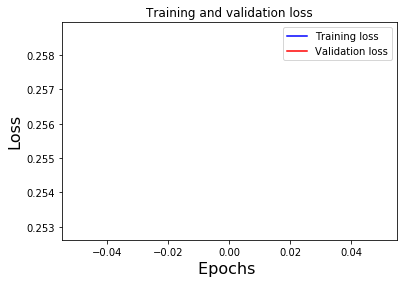

<Figure size 432x288 with 0 Axes>

Epoch: 2/7... Training loss: 0.2443 Validation loss: 0.2428


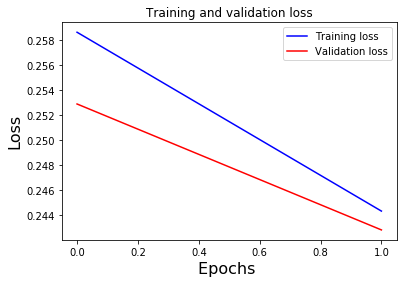

<Figure size 432x288 with 0 Axes>

Epoch: 3/7... Training loss: 0.2203 Validation loss: 0.2314


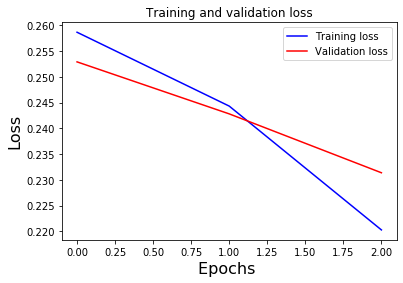

<Figure size 432x288 with 0 Axes>

Epoch: 4/7... Training loss: 0.2194 Validation loss: 0.2336


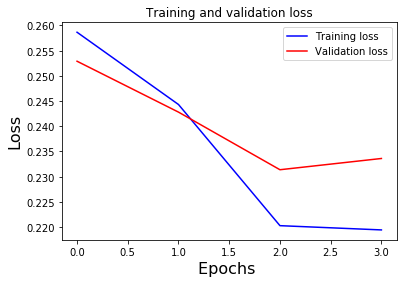

<Figure size 432x288 with 0 Axes>

Epoch: 5/7... Training loss: 0.2096 Validation loss: 0.2142


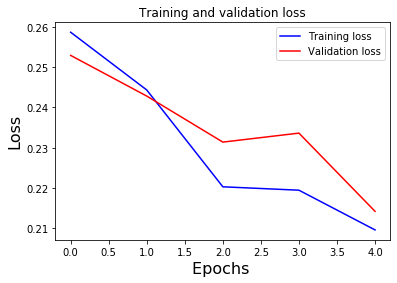

<Figure size 432x288 with 0 Axes>

Epoch: 6/7... Training loss: 0.2177 Validation loss: 0.2122


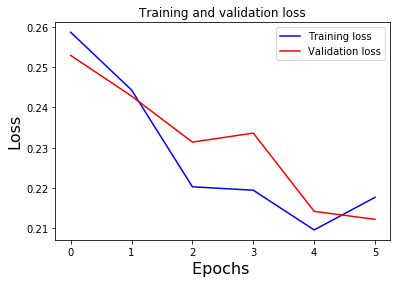

<Figure size 432x288 with 0 Axes>

Epoch: 7/7... Training loss: 0.2047 Validation loss: 0.2273


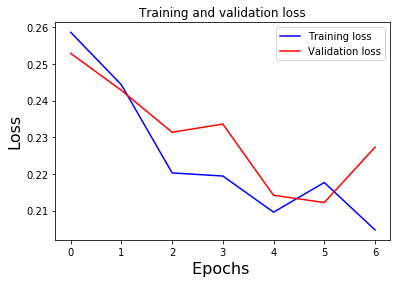

<Figure size 432x288 with 0 Axes>

In [0]:
for e in range(epochs):
    total_batch = int( N_input/ batch_size)
    for ibatch in range(total_batch):
        x_train_noisy , imgs_train  = next_batch(batch_size , train_imgs , train_origins)
        x_test_noisy , imgs_test =  next_batch(batch_size , test_imgs, test_origins)

        x_train_noisy = x_train_noisy.reshape((-1,28,28,1))
        imgs_train = imgs_train.reshape((-1,28,28,1)) 
        x_test_noisy = x_test_noisy.reshape((-1,28,28,1))
        imgs_test = imgs_test.reshape((-1,28,28,1))
            
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_:x_train_noisy ,targets_:imgs_train, learning_rate:lr})

        batch_cost_test = sess.run(cost, feed_dict={inputs_:x_test_noisy,targets_:imgs_test})
    if (e + 1) % display_step == 0:
        print("Epoch: {}/{}...".format(e + 1, epochs),
              "Training loss: {:.4f}".format(batch_cost),
              "Validation loss: {:.4f}".format(batch_cost_test))

    loss.append(batch_cost)
    valid_loss.append(batch_cost_test)
    plt.plot(range(e + 1), loss, 'b', label='Training loss')
    plt.plot(range(e + 1), valid_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()
    saver.save(sess, './encode_model/')


画出结果。

Original Images


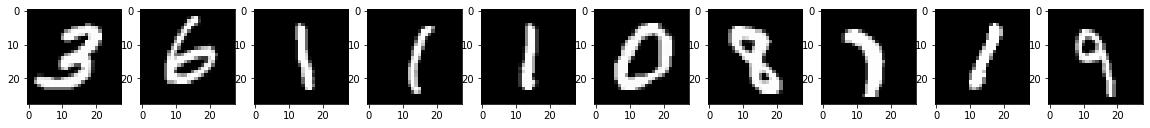

Multimode fiber images


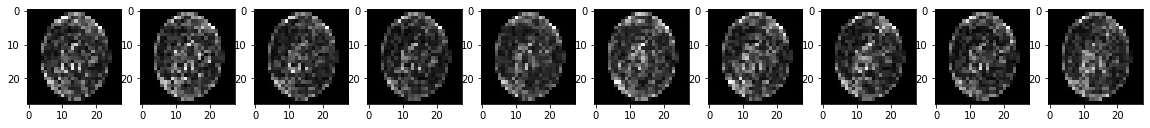

Reconstruction of Multimode fiber Images


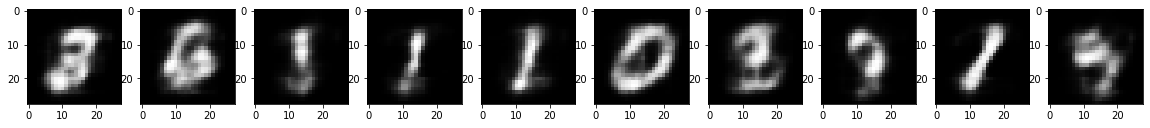

In [0]:
x_test_noisy , imgs_test = next_batch ( 10 , test_imgs, test_origins)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

x_test_noisy = x_test_noisy.reshape((-1,28,28,1))
imgs_test = imgs_test.reshape((-1,28,28,1))

recon_img = sess.run([decoded], feed_dict={inputs_: x_test_noisy})[0]
plt.figure(figsize=(20, 4))
plt.title('Reconstructed Images')
print("Original Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(imgs_test[i,...,0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Multimode fiber images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test_noisy[i,...,0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Multimode fiber Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(recon_img[i,...,0], cmap='gray')
plt.show()
writer.close()
sess.close()